Import libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

Access Dataset

In [4]:
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path('./archive').with_suffix('')

Verify Images Count

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

16170


Open Image Test

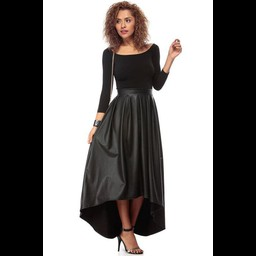

In [6]:
black_dress = list(data_dir.glob('black_dress/*'))
PIL.Image.open(str(black_dress[0]))

Set Parameters

In [7]:
batch_size = 32
img_height = 96
img_width = 96

Load images onto disk w/ 80-20 training-validation split

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 16170 files belonging to 37 classes.
Using 12936 files for training.
Found 16170 files belonging to 37 classes.
Using 3234 files for validation.
['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'black_suit', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts', 'brown_hoodie', 'brown_pants', 'brown_shoes', 'green_pants', 'green_shirt', 'green_shoes', 'green_shorts', 'green_suit', 'pink_hoodie', 'pink_pants', 'pink_skirt', 'red_dress', 'red_hoodie', 'red_pants', 'red_shirt', 'red_shoes', 'silver_shoes', 'silver_skirt', 'white_dress', 'white_pants', 'white_shoes', 'white_shorts', 'white_suit', 'yellow_dress', 'yellow_shorts', 'yellow_skirt']


Visualize 9 images from training

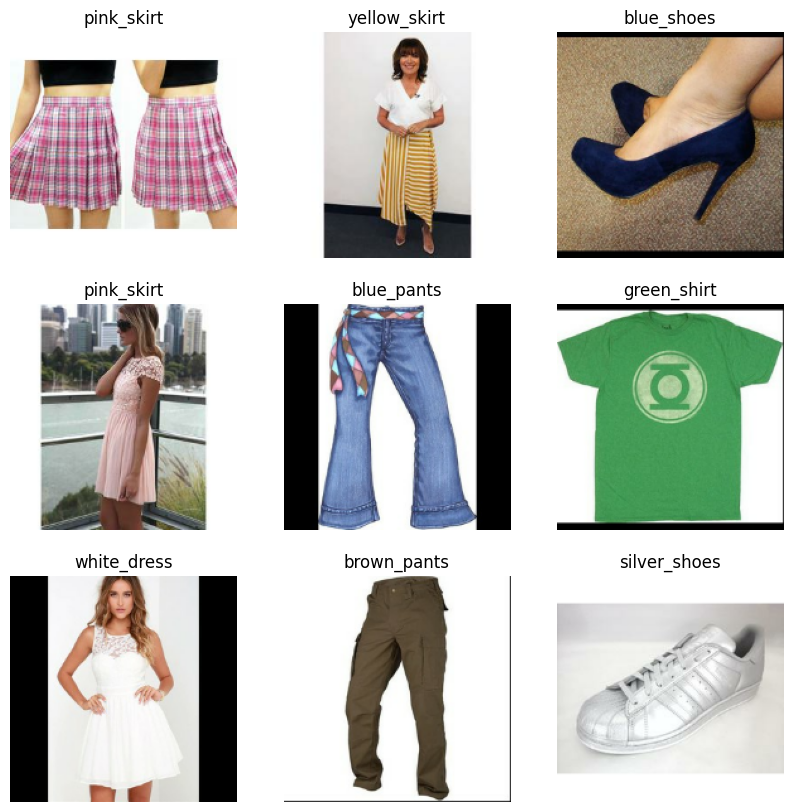

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Train_ds sizes

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Buffered Prefetching

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Scale RGB channels to range from 0 -> 1

In [12]:
normalization_layer = layers.Rescaling(1./255)

Model Architecture and Data_augmentation definition

In [76]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, 3),  
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Data Augmentation Visualization

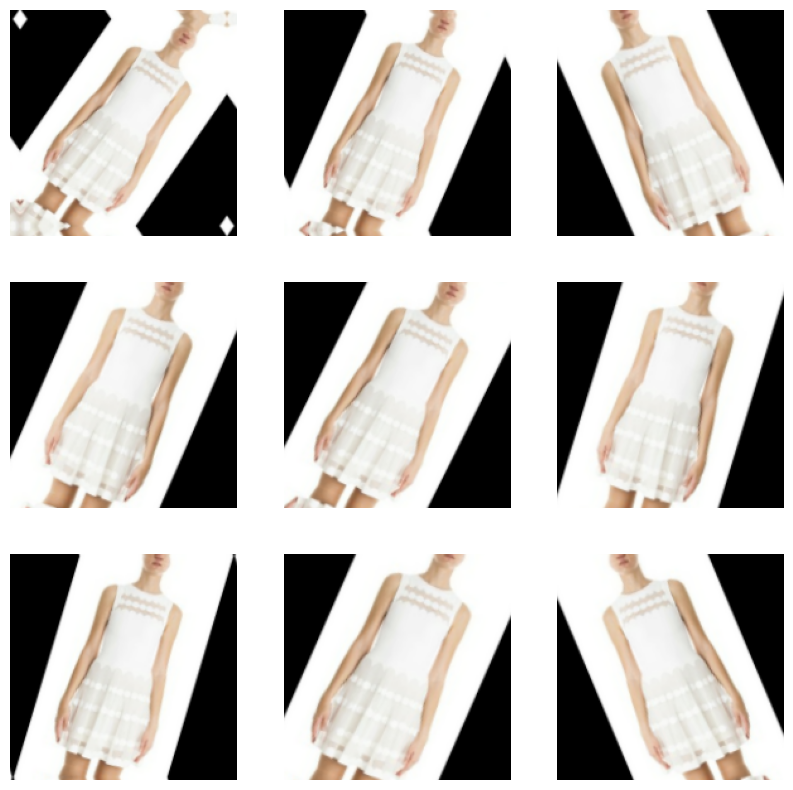

In [77]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model Compile

In [78]:
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary and Training

In [79]:
model.summary()

epochs=8
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_40 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_41 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                   

KeyboardInterrupt: 

Visualize Training

Save All Model Data

In [38]:
model.save('my_model_RMSprop.keras')

Load Model

In [99]:
model = tf.keras.models.load_model('my_model_RMSprop.keras')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

Visualize Training

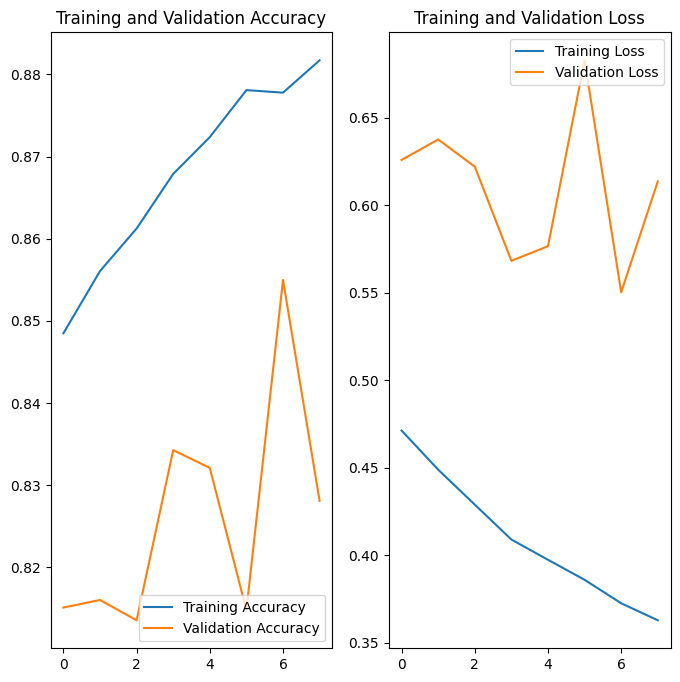

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Prediction on New Image

In [104]:
new_image_path = pathlib.Path('./Predictions/IMG_3153').with_suffix('.jpg')

img = tf.keras.utils.load_img(
    new_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 190ms/step
This image most likely belongs to black_dress with a 37.00 percent confidence.


Adam: 
This image most likely belongs to black_suit with a 71.68 percent confidence.
This image most likely belongs to silver_shoes with a 97.20 percent confidence.

RMS: 
This image most likely belongs to black_shoes with a 54.55 percent confidence.
This image most likely belongs to silver_shoes with a 94.16 percent confidence.

In [57]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0
